# **Proyecto Final - Lending Club**

## **Curso:** Análisis de grandes volúmenes de datos

## **Tecnológico de Monterrey**

## Predicción de riesgo crediticio y segmentación de clientes

## **Equipo :** 13
 **Integrantes :** 
- Kevin Balderas Sánchez – A01795149
- Alan Jasso Arenas – A01383272
- José Florencio Maguey Peralta – A01796727
- Oscar Luis Guadarrama Jiménez – A01796245

---


## **Introducción**

Lending Club es una plataforma de préstamos entre particulares (peer-to-peer) en la que miles de personas solicitan financiamiento para diversos fines. Sin embargo, no todos los solicitantes cumplen con sus obligaciones de pago, lo que representa un riesgo financiero importante para los inversionistas.

Este proyecto tiene como objetivo analizar un conjunto de datos reales de Lending Club y aplicar técnicas de aprendizaje automático para:

- **Predecir** si un préstamo será pagado o no (clasificación supervisada).
- **Agrupar** a los clientes según patrones comunes (clustering no supervisado).

Para lograr esto, se seguirá un flujo estructurado que incluye exploración de datos, limpieza, creación de una muestra representativa, división de conjuntos de entrenamiento y prueba, entrenamiento de modelos, evaluación de resultados y conclusiones.

El enfoque utilizado busca ser reproducible, escalable y fácilmente adaptable a otras plataformas de análisis de crédito.

---


# **1. Inicialización del entorno**

En esta sección se configura el entorno de desarrollo necesario para procesar grandes volúmenes de datos utilizando PySpark.

Además, se importarán todas las librerías necesarias, agrupadas por funcionalidad: transformación de datos, modelado, evaluación y visualización.


## 1.1 Importación de librerías

A continuación se realiza la importación de todas las librerías necesarias para el desarrollo del proyecto.

Estas se encuentran organizadas por funcionalidad:

- **Sesión Spark:** creación y configuración del entorno distribuido.
- **Transformaciones:** funciones para manipulación y limpieza de datos.
- **Preprocesamiento:** herramientas para preparar los datos antes de entrenar modelos.
- **Modelado supervisado:** Random Forest.
- **Modelado no supervisado:** K-means 
- **Evaluación de modelos:** métricas para clasificación binaria y multiclase.
- **Visualización y análisis:** gráficas y análisis complementarios.
- **Herramientas adicionales:** utilidades de `scikit-learn` para validación y métricas.


In [60]:
# -------------------------
# SESIÓN SPARK Y CONFIGURACIÓN
# -------------------------
from pyspark.sql import SparkSession

# -------------------------
# TRANSFORMACIONES EN SPARK
# -------------------------
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, when, isnan, count, round, regexp_replace, expr, lit,
    percentile_approx, first, sum, skewness, log1p,concat_ws
)
from functools import reduce
from pyspark.sql.types import IntegerType
from pyspark.sql import DataFrame

# -------------------------
# PREPROCESAMIENTO
# -------------------------
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

# -------------------------
# MODELOS SUPERVISADOS
# -------------------------
from pyspark.ml.classification import RandomForestClassifier

# -------------------------
# MODELOS NO SUPERVISADOS
# -------------------------
from pyspark.ml.clustering import KMeans

# -------------------------
# EVALUACIÓN DE MODELOS
# -------------------------
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
    ClusteringEvaluator
)

# -------------------------
# ANÁLISIS Y VISUALIZACIÓN
# -------------------------
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# LIBRERÍAS ADICIONALES DE SKLEARN
# -------------------------
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold



## 1.2 Creación de la sesión Spark

Apache Spark requiere una sesión activa para poder ejecutar operaciones de análisis y procesamiento distribuido.

En esta sub-sección se inicializa la sesión de Spark con configuraciones personalizadas para uso local. Estas configuraciones están optimizadas para aprovechar todos los núcleos de procesamiento disponibles y asignar suficiente memoria, lo cual es especialmente útil cuando se trabaja con grandes volúmenes de datos como los de Lending Club.

Las configuraciones incluyen:

- Nombre de la aplicación.
- Modo de ejecución local (`local[*]`).
- Asignación de memoria al driver y a los ejecutores.
- Parámetros de paralelismo y particionamiento por defecto.



In [2]:
spark = SparkSession.builder \
    .appName("Proyecto Final") \
    .master("local[*]") \
    .config("spark.driver.memory", "48g") \
    .config("spark.executor.memory", "48g") \
    .config("spark.sql.shuffle.partitions", "32") \
    .config("spark.default.parallelism", "32") \
    .getOrCreate()
spark

# **2. Carga y exploración inicial de los datos**

En esta sección se realiza la importación del conjunto de datos original de Lending Club y una primera exploración para entender su estructura.

Este dataset contiene registros históricos de préstamos otorgados a través de la plataforma Lending Club, incluyendo múltiples variables relacionadas con los solicitantes (como nivel de ingresos, tipo de vivienda o antigüedad laboral) y con los préstamos (como monto solicitado, tasa de interés, estado del préstamo, entre otros).

El objetivo principal de esta sección es:

- Cargar el archivo `loan.csv` con datos reales.
- Visualizar las primeras filas del dataset.
- Analizar la estructura general del conjunto de datos: tipos de variables, número de registros, presencia de valores nulos, etc.
- Obtener estadísticas descriptivas que permitan tener un panorama inicial del comportamiento de los datos.


## 2.1 Carga del dataset

Para este proyecto se utilizará un archivo en formato `.csv` con datos históricos de préstamos proporcionados por la plataforma Lending Club.

Este archivo contiene una gran variedad de variables que describen las características financieras y demográficas de los solicitantes, así como información sobre los préstamos otorgados y su estado final.

En esta sub-sección se realiza la carga del archivo `loan.csv` utilizando PySpark. Para ello se emplean dos configuraciones clave:

- `header=True`: para que Spark reconozca la primera fila como encabezado con nombres de columna.
- `inferSchema=True`: para que Spark detecte automáticamente el tipo de dato de cada columna.

Una vez cargado el archivo, se visualizarán las primeras filas del conjunto de datos y el esquema inferido.



In [3]:
# Cargar el dataset
df = spark.read.option("header", True).option("inferSchema", True).csv("./loan.csv")

# Mostrar las primeras filas
df.show(5)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-------

## 2.2 Vista preliminar del dataset

Después de cargar los datos, es fundamental realizar una exploración inicial para conocer la estructura general del dataset.

En esta sub-sección se revisarán los siguientes aspectos:

- Número total de registros (filas) y columnas.
- Esquema del DataFrame, incluyendo nombre y tipo de dato de cada variable.
- Presencia de valores nulos por columna.
- Estadísticas descriptivas de las variables numéricas (media, desviación estándar, mínimo, máximo, etc.).

Esta información servirá como base para las decisiones que se tomen en las etapas de limpieza, selección de variables y modelado posterior.


In [4]:
#Número total de registros (filas) y columnas.
filas = df.count()
columnas = len(df.columns)
print(f"Registros: {filas} | Columnas: {columnas}")


Registros: 2260668 | Columnas: 145


In [5]:
# Imprimir el esquema del dataframe: nombres de columnas y tipos de datos
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

In [6]:
# Valores nulos por columna
df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c)
    for c in df.columns
]).show(truncate=False)


+-------+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+-------+-------+-------+-----+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+--

In [7]:
df.summary().show()


+-------+----+---------+------------------+------------------+------------------+----------+------------------+-----------------+-------+---------+--------------------+----------+--------------+------------------+-------------------+---------------+-----------+-----------+----+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+----------------------+----------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------------+-----------------+------------------+------------------+--------------------------+---------------------------+------------------+------------------+-----------------

## 2.3 Conversión inicial de tipos de datos

Durante la carga automática del dataset, Spark puede asignar tipos de datos incorrectos a algunas columnas, especialmente cuando existen valores nulos o formatos inconsistentes.

En esta sub-sección se realizará una conversión manual y controlada de los tipos de dato, asegurando que cada variable tenga el formato adecuado para su análisis posterior. Algunos de los casos más comunes a corregir son:

- Columnas numéricas que aparecen como tipo `string`.
- Fechas que se registran como `string` y deben convertirse a `date`.
- Variables categóricas que se mantienen como `string`, pero que serán transformadas más adelante con codificadores.

Este paso permitirá evitar errores en las siguientes fases del pipeline, como el preprocesamiento y el modelado.


In [8]:
tipos_esperados = {
    "loan_amnt": "int",
    "funded_amnt": "int",
    "funded_amnt_inv": "double",
    "term": "string",
    "int_rate": "double",
    "installment": "double",
    "grade": "string",
    "sub_grade": "string",
    "emp_title": "string",
    "emp_length": "string",
    "home_ownership": "string",
    "annual_inc": "double",
    "verification_status": "string",
    "issue_d": "string",
    "loan_status": "string",
    "pymnt_plan": "string",
    "purpose": "string",
    "title": "string",
    "zip_code": "string",
    "addr_state": "string",
    "dti": "double",
    "delinq_2yrs": "int",
    "earliest_cr_line": "int",
    "inq_last_6mths": "int",
    "open_acc": "int",
    "pub_rec": "int",
    "revol_bal": "int",
    "revol_util": "double",
    "total_acc": "int",
    "initial_list_status": "string",
    "out_prncp": "int",
    "out_prncp_inv": "double",
    "total_pymnt": "double",
    "total_pymnt_inv": "double",
    "total_rec_prncp": "double",
    "total_rec_int": "double",
    "total_rec_late_fee": "double",
    "recoveries": "double",
    "collection_recovery_fee": "double",
    "last_pymnt_d": "string",
    "last_pymnt_amnt": "double",
    "last_credit_pull_d": "string",
    "collections_12_mths_ex_med": "int",
    "policy_code": "int",
    "application_type": "string",
    "acc_now_delinq": "int",
    "tot_coll_amt": "int",
    "tot_cur_bal": "int",
    "total_rev_hi_lim": "int",
    "acc_open_past_24mths": "int",
    "avg_cur_bal": "double",
    "bc_open_to_buy": "int",
    "bc_util": "double",
    "chargeoff_within_12_mths": "double",
    "delinq_amnt": "int",
    "mo_sin_old_il_acct": "int",
    "mo_sin_old_rev_tl_op": "int",
    "mo_sin_rcnt_rev_tl_op": "int",
    "mo_sin_rcnt_tl": "int",
    "mort_acc": "int",
    "mths_since_recent_bc": "int",
    "mths_since_recent_inq": "int",
    "num_accts_ever_120_pd": "int",
    "num_actv_bc_tl": "int",
    "num_actv_rev_tl": "int",
    "num_bc_sats": "int",
    "num_bc_tl": "int",
    "num_il_tl": "int",
    "num_op_rev_tl": "int",
    "num_rev_accts": "int",
    "num_rev_tl_bal_gt_0": "int",
    "num_sats": "int",
    "num_tl_120dpd_2m": "int",
    "num_tl_30dpd": "int",
    "num_tl_90g_dpd_24m": "int",
    "num_tl_op_past_12m": "int",
    "pct_tl_nvr_dlq": "double",
    "percent_bc_gt_75": "double",
    "pub_rec_bankruptcies": "int",
    "tax_liens": "int",
    "tot_hi_cred_lim": "int",
    "total_bal_ex_mort": "int",
    "total_bc_limit": "int",
    "total_il_high_credit_limit": "int",
    "hardship_flag": "string",
    "disbursement_method": "string",
    "debt_settlement_flag": "string",
}


In [9]:
# Corrección automática de tipos según tipos_esperados
for columna, tipo_esperado in tipos_esperados.items():
    if columna in dict(df.dtypes):
        tipo_actual = dict(df.dtypes)[columna]
        if tipo_actual != tipo_esperado:
            print(f"Corrigiendo: {columna} de {tipo_actual} a {tipo_esperado}")
            
            # Limpieza de strings si es necesario para convertir a double
            if tipo_esperado == "double" and tipo_actual == "string":
                df = df.withColumn(columna, regexp_replace(col(columna), "[,%$]", "").cast("double"))
            else:
                df = df.withColumn(columna, col(columna).cast(tipo_esperado))


Corrigiendo: annual_inc de string a double
Corrigiendo: dti de string a double
Corrigiendo: delinq_2yrs de string a int
Corrigiendo: earliest_cr_line de string a int
Corrigiendo: inq_last_6mths de string a int
Corrigiendo: open_acc de string a int
Corrigiendo: pub_rec de string a int
Corrigiendo: revol_bal de string a int
Corrigiendo: revol_util de string a double
Corrigiendo: total_acc de string a int
Corrigiendo: out_prncp de string a int
Corrigiendo: out_prncp_inv de string a double
Corrigiendo: total_pymnt de string a double
Corrigiendo: total_pymnt_inv de string a double
Corrigiendo: total_rec_prncp de string a double
Corrigiendo: total_rec_int de string a double
Corrigiendo: total_rec_late_fee de string a double
Corrigiendo: recoveries de string a double
Corrigiendo: collection_recovery_fee de string a double
Corrigiendo: last_pymnt_amnt de string a double
Corrigiendo: collections_12_mths_ex_med de string a int
Corrigiendo: policy_code de string a int
Corrigiendo: acc_now_delinq 

# **3. Limpieza y preprocesamiento**

Una vez cargados y tipificados correctamente los datos, es necesario preparar el conjunto de datos para su análisis y modelado. Esta etapa es crucial para garantizar la calidad de los resultados y evitar errores durante el entrenamiento de los modelos.

Las tareas que se llevarán a cabo en esta sección incluyen:

- Eliminación de columnas irrelevantes, redundantes o con demasiados valores nulos.
- Tratamiento de valores faltantes.
- Transformación de variables categóricas.
- Generación de nuevas variables (en caso necesario).
- Normalización o escalado si se considera útil.
- Preparación final del conjunto de datos con las variables seleccionadas para el modelado.

Estas transformaciones permitirán reducir la complejidad del dataset, mejorar la calidad de los datos y facilitar el aprendizaje de los modelos que se implementarán posteriormente.


## 3.1 Eliminación de columnas con muchos valores nulos

Uno de los primeros pasos fundamentales en la limpieza de datos es identificar y eliminar aquellas columnas que contienen un alto porcentaje de valores nulos.

Las columnas con un exceso de valores faltantes suelen ser poco confiables o difíciles de imputar sin introducir sesgos significativos. En este proyecto se define un umbral del **30%**: todas las columnas que tengan más del 30% de valores nulos serán eliminadas.

Esta decisión busca mantener la calidad de la información sin perder demasiados atributos útiles.


In [10]:
#ELminar columans con el 30% de vlaores nuloso 
# Calcular total de registros
total_rows = df.count()

# Calcular porcentaje de nulos por columna y quedarte con las que tienen menos del 20%
col_porcentaje_nulos = [
   (sum(when((col(c).isNull()) | (col(c) == ''), 1).otherwise(0)) / total_rows).alias(c)
    for c in df.columns
]

# Generar DataFrame con porcentaje de nulos
porcentaje_nulos_df = df.select(col_porcentaje_nulos)
porcentaje_nulos = porcentaje_nulos_df.collect()[0].asDict()

# Filtrar columnas que tienen menos de 20% de nulos
columnas_validas = [k for k, v in porcentaje_nulos.items() if v < 0.3]

# Seleccionar solo las columnas válidas
df = df.select(*columnas_validas)

print(f"Columnas seleccionadas con <30% de nulos: {len(columnas_validas)}")


Columnas seleccionadas con <30% de nulos: 86


## 3.2 Eliminación de columnas categóricas con alta cardinalidad

Las columnas categóricas con demasiados valores únicos (alta cardinalidad) pueden ser problemáticas para los modelos de aprendizaje automático, especialmente si no aportan información útil o presentan una alta dispersión.

En este proyecto, se define un umbral de **10,000 valores distintos**: todas las columnas categóricas que excedan este número serán eliminadas del conjunto de datos.

Este umbral se basa en dos criterios:

- Dificultad de codificación eficiente (OneHotEncoding o StringIndexer).
- Posible irrelevancia de columnas con demasiadas categorías específicas (como títulos de empleo, nombres personalizados, etc.).

La eliminación de estas columnas permite reducir la complejidad del dataset y mejorar el rendimiento del pipeline de procesamiento y modelado.


In [11]:
# Identificar columnas de tipo string con más de 10,000 valores únicos
columnas_texto_libre = []

for c in df.columns:
    if dict(df.dtypes)[c] == "string":
        num_valores_unicos = df.select(c).distinct().count()
        if num_valores_unicos > 10000:
            columnas_texto_libre.append(c)

# Mostrar las columnas identificadas
print("Columnas con alta cardinalidad (>10,000 categorías únicas):")
print(columnas_texto_libre)

# Eliminar las columnas del DataFrame
df = df.drop(*columnas_texto_libre)

print(f"Número de columnas eliminadas: {len(columnas_texto_libre)}")
print(f"Número de columnas restantes: {len(df.columns)}")



Columnas con alta cardinalidad (>10,000 categorías únicas):
['emp_title', 'title']
Número de columnas eliminadas: 2
Número de columnas restantes: 84


## 3.3 Eliminación de columnas numéricas altamente correlacionadas

Las variables numéricas altamente correlacionadas entre sí pueden introducir redundancia en el modelo y dificultar la interpretación de los resultados. Además, en algunos algoritmos como regresión logística, estas correlaciones pueden provocar problemas de multicolinealidad.

Para mitigar esto, en esta sub-sección se calculará la **matriz de correlación de Pearson** entre todas las variables numéricas y se eliminarán aquellas columnas cuya correlación absoluta con otra columna sea **mayor a 0.95**.

Este umbral busca conservar únicamente una de las dos variables fuertemente correlacionadas, reduciendo la dimensionalidad del conjunto de datos sin pérdida significativa de información.


In [12]:
# Seleccionar columnas numéricas del DataFrame
columnas_numericas = [c for c, t in df.dtypes if t in ("double", "int")]

# Tomar una muestra del 10% del dataset para evitar saturar memoria
df_sample_pd = df.select(columnas_numericas).sample(False, 0.10, seed=1).toPandas()

# Calcular matriz de correlación absoluta de Pearson
cor_matrix = df_sample_pd.corr().abs()

# Umbral para eliminar columnas altamente correlacionadas
umbral = 0.95
columnas_correladas = set()

# Recorrer matriz de correlación y marcar columnas redundantes
for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):
        col1 = cor_matrix.columns[i]
        col2 = cor_matrix.columns[j]
        if cor_matrix.iloc[i, j] > umbral:
            print(f"Alta correlación entre: {col1} y {col2} (r = {cor_matrix.iloc[i, j]:.4f})")
            columnas_correladas.add(col2)  # Conservamos col1, eliminamos col2

# Eliminar columnas redundantes del DataFrame original
df = df.drop(*list(columnas_correladas))

# Mostrar resultados
print(f"Columnas eliminadas por redundancia lineal: {len(columnas_correladas)}")
print(f"Total de columnas restantes: {len(df.columns)}")


Alta correlación entre: loan_amnt y funded_amnt (r = 0.9998)
Alta correlación entre: loan_amnt y funded_amnt_inv (r = 0.9990)
Alta correlación entre: funded_amnt y funded_amnt_inv (r = 0.9993)
Alta correlación entre: open_acc y num_sats (r = 0.9990)
Alta correlación entre: out_prncp y out_prncp_inv (r = 0.9999)
Alta correlación entre: total_pymnt y total_pymnt_inv (r = 0.9992)
Alta correlación entre: total_pymnt y total_rec_prncp (r = 0.9671)
Alta correlación entre: total_pymnt_inv y total_rec_prncp (r = 0.9665)
Alta correlación entre: tot_cur_bal y tot_hi_cred_lim (r = 0.9793)
Alta correlación entre: num_actv_rev_tl y num_rev_tl_bal_gt_0 (r = 0.9835)
Columnas eliminadas por redundancia lineal: 8
Total de columnas restantes: 76


## 3.4 Eliminación de columnas con baja varianza

Las columnas con muy poca variación en sus valores no aportan información significativa a los modelos de aprendizaje automático, ya que no ayudan a diferenciar entre clases ni a establecer patrones útiles.

En esta sub-sección se eliminarán:

- Columnas numéricas cuya varianza sea igual a 0.
- Columnas categóricas con una única categoría (baja varianza cualitativa).

Estas columnas no solo son irrelevantes para el aprendizaje del modelo, sino que también pueden aumentar el tiempo de procesamiento y generar ruido.

Este filtrado busca conservar únicamente aquellas variables que ofrecen información útil para la clasificación o segmentación.


In [13]:
# Umbral para considerar que una variable tiene baja varianza (70%)
umbral = 0.70
total_rows = df.count()

# ---------------------------
# Categóricas con baja varianza
# ---------------------------
cat_columns = [c for c, t in df.dtypes if t == "string"]
columnas_baja_varianza = []

for c in cat_columns:
    top_valor = df.groupBy(c).count().orderBy("count", ascending=False).first()
    if top_valor and (top_valor["count"] / total_rows) >= umbral:
        print(f"{c}: {top_valor['count'] / total_rows:.2%} del dataset tiene '{top_valor[c]}'")
        columnas_baja_varianza.append(c)

# Eliminar columnas categóricas con baja varianza
df = df.drop(*columnas_baja_varianza)
print(f"\nColumnas categóricas eliminadas por baja varianza: {len(columnas_baja_varianza)}")


# ---------------------------
# Numéricas con valor dominante (>70%)
# ---------------------------
numeric_columns = [c for c, t in df.dtypes if t in ("double", "int")]
columnas_valor_dominante = []

for c in numeric_columns:
    valor_mas_frecuente = (
        df.groupBy(c)
        .count()
        .orderBy("count", ascending=False)
        .first()
    )

    if valor_mas_frecuente:
        valor = valor_mas_frecuente[0]
        cuenta = valor_mas_frecuente["count"]
        porcentaje = cuenta / total_rows

        if porcentaje >= umbral:
            print(f"{c}: {porcentaje:.2%} de los valores son '{valor}'")
            columnas_valor_dominante.append(c)

# Eliminar columnas numéricas con valor dominante
df = df.drop(*columnas_valor_dominante)
print(f"\nColumnas numéricas eliminadas por valor dominante: {len(columnas_valor_dominante)}")
print(f"Total de columnas restantes: {len(df.columns)}")

term: 71.21% del dataset tiene ' 36 months'
pymnt_plan: 99.97% del dataset tiene 'n'
application_type: 94.65% del dataset tiene 'Individual'
hardship_flag: 99.95% del dataset tiene 'N'
disbursement_method: 96.53% del dataset tiene 'Cash'
debt_settlement_flag: 98.53% del dataset tiene 'N'

Columnas categóricas eliminadas por baja varianza: 6
delinq_2yrs: 81.34% de los valores son '0'
pub_rec: 84.16% de los valores son '0'
total_rec_late_fee: 96.25% de los valores son '0.0'
recoveries: 92.14% de los valores son '0.0'
collection_recovery_fee: 92.52% de los valores son '0.0'
collections_12_mths_ex_med: 98.33% de los valores son '0'
policy_code: 99.99% de los valores son '1'
acc_now_delinq: 99.60% de los valores son '0'
tot_coll_amt: 82.11% de los valores son '0'
chargeoff_within_12_mths: 99.22% de los valores son '0.0'
delinq_amnt: 99.67% de los valores son '0'
num_accts_ever_120_pd: 74.64% de los valores son '0'
num_tl_120dpd_2m: 93.15% de los valores son '0'
num_tl_30dpd: 96.63% de los v

## 3.5 Eliminación de columnas con fuga de información

La fuga de información (data leakage) ocurre cuando se incluyen en el entrenamiento variables que contienen directa o indirectamente información sobre el resultado que se pretende predecir. Esto genera modelos artificialmente precisos en fase de entrenamiento, pero poco útiles en escenarios reales.

En este proyecto se eliminarán todas las columnas que:

- Contengan información que solo está disponible después del préstamo (como pagos realizados, saldos finales, o fechas de pago).
- Estén altamente relacionadas con la variable objetivo (`loan_status`) por diseño.

Este paso es crucial para asegurar que el modelo aprenda únicamente a partir de información disponible en el momento de la solicitud del préstamo, imitando una situación real.


In [14]:
#Columnas eliminadas por contener información posterior al préstamo
columnas_fuga_info = [
    "issue_d",             # Fecha del préstamo
    "last_pymnt_d",        # Fecha del último pago
    "last_credit_pull_d",  # Última revisión de crédito
]

df = df.drop(*[c for c in columnas_fuga_info if c in df.columns])
print(f"Columnas eliminadas por fuga de información: {len(columnas_fuga_info)}")
print(f"Total de columnas restantes en el DataFrame: {len(df.columns)}")

Columnas eliminadas por fuga de información: 3
Total de columnas restantes en el DataFrame: 50


## 3.6 Eliminación de columnas irrelevantes o redundantes

Además de eliminar columnas con fuga de información, es importante revisar y eliminar variables que no aportan valor al análisis por otras razones, como:

- **Irrelevancia:** columnas con información personal, metadatos técnicos o atributos poco explicativos.
- **Redundancia:** variables que están representadas de forma más general o repetida en otras columnas.
- **Diseño técnico:** variables calculadas automáticamente que no reflejan comportamientos reales ni tienen utilidad predictiva.

La eliminación de estas columnas permite simplificar el conjunto de datos, reducir la dimensionalidad y evitar sesgos innecesarios en los modelos.


In [15]:
# Columnas consideradas irrelevantes por diseño o redundancia obvia
columnas_irrelevantes = [
    "zip_code",           # Alta cardinalidad, dato personal
    "addr_state",         # Baja capacidad explicativa
    "sub_grade",          # Ya contenida en 'grade'
    "initial_list_status" # Metadata técnica
]

df = df.drop(*[c for c in columnas_irrelevantes if c in df.columns])
print(f"Columnas eliminadas por irrelevancia justificada: {len(columnas_irrelevantes)}")

# Columnas redundantes por definición técnica
columnas_a_eliminar_por_definicion = [
    "bc_open_to_buy",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "num_bc_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "total_bc_limit"
]

df = df.drop(*[c for c in columnas_a_eliminar_por_definicion if c in df.columns])
print(f"Columnas eliminadas por redundancia técnica: {len(columnas_a_eliminar_por_definicion)}")
print(f"Total de columnas restantes en el DataFrame: {len(df.columns)}")

Columnas eliminadas por irrelevancia justificada: 4
Columnas eliminadas por redundancia técnica: 9
Total de columnas restantes en el DataFrame: 37


### 3.7 Imputación de valores faltantes

Después de eliminar columnas con un alto porcentaje de valores nulos, aún pueden existir columnas que contienen algunos valores faltantes. Para asegurar la integridad del dataset y evitar errores en las etapas siguientes del pipeline, se procederá a imputar estos valores.

Se utilizarán las siguientes estrategias:

- **Para variables numéricas:** se imputará utilizando la **media** o la **mediana**, según la distribución de la variable.
- **Para variables categóricas:** se imputará con la **moda** (valor más frecuente).

Estas técnicas son simples pero efectivas, y permiten mantener una aproximación conservadora al comportamiento de cada variable.


In [16]:
# Mostrar número de valores nulos por columna
print("Valores nulos por columna:")
df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show(truncate=False)


Valores nulos por columna:
+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+-------+----+--------------+--------+---------+----------+---------+---------+-----------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+------------------+--------------+----------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|dti |inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_tl_op_past_12m|pct_tl_nvr_dlq|percent_bc_gt_75|total_bal_ex_mort|tot

In [17]:
numeric_columns = [c for c, t in df.dtypes if t in ("double", "int")]
# Imputación de variables numéricas con MEDIANA
for col_name in numeric_columns:
    mediana = df.approxQuantile(col_name, [0.5], 0.01)[0]
    df = df.withColumn(
        col_name,
        when(col(col_name).isNull(), lit(mediana)).otherwise(col(col_name))
    )
cat_columns = [c for c, t in df.dtypes if t == "string"]
# Imputación de variables categóricas con MODO (valor más frecuente)
for col_name in cat_columns:
    modo = (df.groupBy(col_name)
                     .count()
                     .orderBy(F.desc("count"))
                     .first()[0])
    df = df.withColumn(
        col_name,
        when(col(col_name).isNull(), lit(modo)).otherwise(col(col_name))
    )


In [18]:
# Mostrar número de valores nulos por columna
print("Valores nulos por columna:")
df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show(truncate=False)

Valores nulos por columna:
+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+-------+---+--------------+--------+---------+----------+---------+---------+-----------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+------------------+--------------+----------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_tl_op_past_12m|pct_tl_nvr_dlq|percent_bc_gt_75|total_bal_ex_mort|total

## 3.8 Revisión de sesgos, outliers y transformaciones

Una vez imputados los valores faltantes, es importante revisar la presencia de valores atípicos (**outliers**) y distribuciones sesgadas (**skewed distributions**) en las variables numéricas.

En esta sub-sección se realiza un análisis combinado de:

- **Asimetría (skewness):** para identificar variables con distribuciones fuertemente sesgadas (asimetría mayor a ±1).
- **Outliers:** mediante el rango intercuartílico (IQR), para detectar variables con una cantidad significativa de valores extremos.

Con base en este análisis, se toma una decisión automática para cada variable numérica:

- **Aplicar transformación logarítmica** (`log1p`) en variables con alta asimetría positiva y más de 10,000 outliers.
- **Eliminar outliers** si la variable tiene valores extremos pero no presenta alta asimetría.
- **Conservar la variable tal como está** si no hay problemas detectados.

Estas transformaciones ayudan a estabilizar la varianza, mejorar la distribución de los datos y aumentar el desempeño de los modelos de aprendizaje.


In [19]:
def eliminar_outliers_spark(df, columnas):
    for nombre_col in columnas:
        # Calcular Q1 y Q3
        q1, q3 = df.approxQuantile(nombre_col, [0.25, 0.75], 0.01)
        iqr = q3 - q1
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Filtrar fuera del IQR
        df = df.filter(
            (col(nombre_col) >= limite_inferior) & (col(nombre_col) <= limite_superior)
        )
        
    return df

# 1. Calcular skewness (asimetría) para cada variable numérica
skew_data = df.select([skewness(c).alias(c) for c in numeric_columns]).toPandas().T
skew_data.columns = ['skewness']
skew_data['feature'] = skew_data.index

# 2. Identificar outliers usando el rango intercuartílico (IQR)
outlier_info = []

for col_name in numeric_columns:
    q1, q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_count = df.filter((col(col_name) < lower) | (col(col_name) > upper)).count()
    outlier_info.append((col_name, outlier_count))

outlier_df = pd.DataFrame(outlier_info, columns=["feature", "outlier_count"])

# 3. Fusionar skewness + outlier info
merged = skew_data.merge(outlier_df, on="feature")

# 4. Clasificar columnas en 3 categorías: aplicar log, eliminar outliers o conservar
merged["decision"] = merged.apply(lambda row:
    "log" if abs(row["skewness"]) > 1.0 and row["outlier_count"] > 10000 else
    "delete" if row["outlier_count"] > 0 and abs(row["skewness"]) < 1.0 else
    "keep", axis=1
)

# 5. Extraer listas por decisión
cols_log = merged[merged["decision"] == "log"]["feature"].tolist()
cols_delete = merged[merged["decision"] == "delete"]["feature"].tolist()
cols_keep = merged[merged["decision"] == "keep"]["feature"].tolist()

# 6. Mostrar resumen de decisiones
print("Columnas para log:", cols_log)
print("Columnas para eliminar outliers:", cols_delete)
print("Columnas para conservar:", cols_keep)

# elimina outliers según IQR.
df_v1 = eliminar_outliers_spark(df, cols_delete)

# Aplicar transformación logarítmica a columnas con alta asimetría y muchos outliers
for c in cols_log:
    df_v1 = df_v1.withColumn(c, log1p(col(c)))

print("Transformaciones aplicadas: eliminación de outliers y log.")


Columnas para log: ['installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'revol_bal', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'total_bal_ex_mort', 'total_il_high_credit_limit']
Columnas para eliminar outliers: ['loan_amnt', 'int_rate', 'bc_util']
Columnas para conservar: ['revol_util', 'percent_bc_gt_75']
Transformaciones aplicadas: eliminación de outliers y log.


## 3.9 Observación final del dataset limpio

Antes de pasar a la etapa de preprocesamiento para modelado, es importante validar el estado actual del conjunto de datos tras todas las tareas de limpieza realizadas.

En esta sub-sección se observará:

- Número total de filas y columnas restantes.
- Número de columnas por tipo de dato.
- Presencia residual de valores nulos (si los hubiera).
- Distribución general de algunas variables clave.
- Estadísticas descriptivas para variables numéricas
- Estadísticas descriptivas para variables categoricas 
Este resumen final sirve como verificación de que el dataset se encuentra en condiciones óptimas para pasar a las fases de transformación, codificación y modelado.


In [20]:
# -----------------------------
# 1. Número total de filas y columnas
# -----------------------------
num_filas = df_v1.count()
num_columnas = len(df_v1.columns)
print(f"Total de registros: {num_filas}")
print(f"Total de columnas: {num_columnas}")

# -----------------------------
# 2. Conteo de columnas por tipo de dato
# -----------------------------
tipos = {}
for col_name, tipo in df_v1.dtypes:
    tipos[tipo] = tipos.get(tipo, 0) + 1

print("\nConteo de columnas por tipo de dato:")
for tipo, cantidad in tipos.items():
    print(f" - {tipo}: {cantidad}")

# -----------------------------
# 3. Verificación de valores nulos residuales
# -----------------------------
print("\nValores nulos restantes por columna:")
df_v1.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df_v1.columns
]).show(truncate=False)

# Eliminar registros que aún contengan valores nulos
filas_antes = df_v1.count()
df_v1 = df_v1.na.drop()
filas_despues = df_v1.count()

print(f"Registros eliminados por contener valores nulos: {filas_antes - filas_despues}")
print(f"Total de registros restantes: {filas_despues}")

# -----------------------------
# 4. Vista de muestra final
# -----------------------------
print("\n Vista de muestra del dataset final:")
df_v1.show(5)


Total de registros: 2178236
Total de columnas: 37

Conteo de columnas por tipo de dato:
 - double: 31
 - string: 6

Valores nulos restantes por columna:
+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+-------+---+--------------+--------+---------+----------+---------+---------+-----------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+------------------+--------------+----------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|purpose|dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|n

In [21]:
#Estadísticas descriptivas para variables numéricas
numeric_columns = [col.name for col in df.schema.fields if col.dataType.simpleString() != 'string']
df_numerics = df.select(numeric_columns)
df_numerics.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+--------------------+------------------+-----------------+------------------+--------------------+---------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+--------------------------+
|summary|         loan_amnt|          int_rate|      installment|        annual_inc|               dti|    inq_last_6mths|          open_acc|        revol_bal|        revol_util|         total_acc|        out_prncp|       total_pymnt|     total_rec_int|  last_pymnt_amnt|      tot_cur_bal| total_rev_hi_lim|acc_open_past_24mths|       avg_cur_bal|          bc_util|          mort_acc|mths_since_re

In [22]:
#Estadísticas descriptivas para variables categoricas 
cat_columns = [col.name for col in df.schema.fields if col.dataType.simpleString() == 'string']
df_strings = df.select(cat_columns)
for col_name in cat_columns:
    total_distintos = df.select(col_name).distinct().count()
    df_strings.groupBy(col_name).count().orderBy("count", ascending=False).show()

+-----+------+
|grade| count|
+-----+------+
|    B|663557|
|    C|650053|
|    A|433027|
|    D|324424|
|    E|135639|
|    F| 41800|
|    G| 12168|
+-----+------+

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|748005|
|   2 years|203676|
|  < 1 year|189988|
|   3 years|180753|
|    1 year|148403|
|       n/a|146907|
|   5 years|139698|
|   4 years|136605|
|   6 years|102628|
|   7 years| 92695|
|   8 years| 91914|
|   9 years| 79395|
| reactors"|     1|
+----------+------+

+--------------+-------+
|home_ownership|  count|
+--------------+-------+
|      MORTGAGE|1111449|
|          RENT| 894929|
|           OWN| 253057|
|           ANY|    996|
|         OTHER|    182|
|          NONE|     54|
|       2 years|      1|
+--------------+-------+

+-------------------+------+
|verification_status| count|
+-------------------+------+
|    Source Verified|886230|
|       Not Verified|744806|
|           Verified|629631|
|              38000|     1|
+-------------

# **4. Construcción de la muestra representativa (M)**

En esta sección se construirá una muestra representativa (`M`) a partir del conjunto original de datos, con el objetivo de facilitar el entrenamiento de modelos sin perder la diversidad ni las proporciones clave de la población.

Para ello, se realizarán las siguientes etapas:

1. **Agrupación de categorías poco frecuentes** en las variables `home_ownership` y `purpose`, con el fin de reducir la complejidad del análisis y evitar combinaciones con muy baja representatividad.

2. **Identificación de combinaciones significativas** entre las variables `purpose`, `home_ownership` y `verification_status`, seleccionando únicamente aquellas con más de 50,000 registros para garantizar solidez estadística.

3. **Aplicación de muestreo aleatorio** del 20% sobre cada combinación válida, generando subconjuntos balanceados (`Mi`) que capturan la estructura poblacional de forma proporcional.

4. **Unión de los subconjuntos `Mi`** para conformar la muestra final `M`, la cual será utilizada en las siguientes etapas del proceso de modelado.

Este procedimiento permite reducir el volumen total de datos manteniendo la calidad y representatividad necesarias para entrenar modelos de aprendizaje automático de manera eficiente.


## 4.1 Agrupación de categorías relevantes

Para reducir la dimensionalidad de las variables categóricas y facilitar una mejor caracterización de la población, se agruparon algunas categorías de baja frecuencia en nuevas clases.

- En `home_ownership`, se agruparon todas las categorías poco frecuentes en una nueva categoría llamada `OTHER`.
- En `purpose`, se unificaron propósitos similares en grupos temáticos: `debt_related`, `large_expense`, `personal_use`, `life_event` y `other`.


In [23]:
# Agrupar categorías frecuentes en 'home_ownership'
categorias_frecuentes = ['MORTGAGE', 'RENT', 'OWN']
df_v1 = df_v1.withColumn(
    "home_ownership",
    when(col("home_ownership").isin(categorias_frecuentes), col("home_ownership"))
    .otherwise("OTHER")
)

# Agrupar categorías en 'purpose'
df_v1 = df_v1.withColumn(
    "purpose",
    when(col("purpose").isin("debt_consolidation", "credit_card"), "debt_related")
    .when(col("purpose").isin("home_improvement", "major_purchase"), "large_expense")
    .when(col("purpose").isin("small_business", "car", "vacation", "house"), "personal_use")
    .when(col("purpose").isin("medical", "wedding", "moving"), "life_event")
    .otherwise("other")
)

## 4.2 Identificación de combinaciones válidas

Se generaron todas las combinaciones posibles entre las variables `purpose`, `home_ownership` y `verification_status`. Posteriormente, se calcularon sus frecuencias relativas y absolutas.

Solo se consideraron aquellas combinaciones con **más de 50,000 registros** para garantizar una muestra robusta y representativa.


In [24]:
total = df_v1.count()

combinaciones = df_v1.groupBy('purpose', 'home_ownership','verification_status') \
    .count() \
    .withColumnRenamed("count", "frecuencia") \
    .withColumn("probabilidad (%)", round((col("frecuencia") / total) * 100, 2)) \
    .orderBy("frecuencia", ascending=False)

print("Combinaciones posibles:", combinaciones.count())
combinaciones.show(truncate=False)

Combinaciones posibles: 61
+-------------+--------------+-------------------+----------+----------------+
|purpose      |home_ownership|verification_status|frecuencia|probabilidad (%)|
+-------------+--------------+-------------------+----------+----------------+
|debt_related |MORTGAGE      |Source Verified    |313275    |14.38           |
|debt_related |RENT          |Source Verified    |293686    |13.48           |
|debt_related |MORTGAGE      |Not Verified       |278403    |12.78           |
|debt_related |MORTGAGE      |Verified           |245792    |11.28           |
|debt_related |RENT          |Not Verified       |237892    |10.92           |
|debt_related |RENT          |Verified           |180049    |8.27            |
|debt_related |OWN           |Source Verified    |72772     |3.34            |
|debt_related |OWN           |Not Verified       |62590     |2.87            |
|large_expense|MORTGAGE      |Not Verified       |50961     |2.34            |
|large_expense|MORTGAGE  

## 4.3 Muestreo aleatorio de subconjuntos `Mi`

A cada combinación válida se le aplicó un muestreo aleatorio del 20% sin reemplazo (`fraction=0.2`), obteniendo un subconjunto `Mi` por cada combinación.

Estos subconjuntos fueron almacenados en una lista para su posterior consolidación.

In [25]:
# Definir umbral mínimo de registros para considerar una combinación válida
UMBRAL = 60000

# Filtrar las combinaciones que superan el umbral
combinaciones_validas = df_v1.groupBy("purpose", "home_ownership", "verification_status") \
    .count() \
    .filter(col("count") > UMBRAL) \
    .collect()

# Crear lista para almacenar cada subconjunto Mi
muestras = []

# Aplicar muestreo del 20% a cada combinación válida y agregarla a la lista
for fila in combinaciones_validas:
    p, h, v = fila["purpose"], fila["home_ownership"], fila["verification_status"]
    
    mi = df_v1.filter(
        (col("purpose") == p) &
        (col("home_ownership") == h) &
        (col("verification_status") == v)
    )
    
    mi = mi.sample(withReplacement=False, fraction=0.2, seed=1)
    muestras.append(mi)

# Confirmar cuántos subconjuntos se generaron
print("Número de subconjuntos Mi generados:", len(muestras))


Número de subconjuntos Mi generados: 8


### 4.4 Unión de subconjuntos y validación de la muestra `M`

La muestra representativa `M` se construyó como la unión de todos los subconjuntos `Mi`.

Finalmente, se validó que la distribución de combinaciones en `M` reflejara las proporciones generales de la población original.

In [26]:
# Unión final para obtener M
M = muestras[0]
for mi in muestras[1:]:
    M = M.union(mi)

print("Total de registros en la muestra M:", M.count())

# Verifica distribución
M.groupBy("purpose", "home_ownership", "verification_status").count().orderBy("count", ascending=False).show(truncate=False)

Total de registros en la muestra M: 337414
+------------+--------------+-------------------+-----+
|purpose     |home_ownership|verification_status|count|
+------------+--------------+-------------------+-----+
|debt_related|MORTGAGE      |Source Verified    |62736|
|debt_related|RENT          |Source Verified    |58884|
|debt_related|MORTGAGE      |Not Verified       |55790|
|debt_related|MORTGAGE      |Verified           |49197|
|debt_related|RENT          |Not Verified       |47630|
|debt_related|RENT          |Verified           |35982|
|debt_related|OWN           |Source Verified    |14604|
|debt_related|OWN           |Not Verified       |12591|
+------------+--------------+-------------------+-----+



# **5. Preparación del Dataset para Modelado**

Para asegurar una correcta preparación del dataset sin fugas de información, se siguió este flujo:

1. **Transformación de la variable objetivo**: se creó una columna binaria `label` a partir de `loan_status`, donde 1 indica riesgo y 0 no riesgo.

2. **División del dataset**: se separó la muestra representativa `M` en conjuntos `train` (80%) y `test` (20%) mediante una partición estratificada.

3. **Definición del pipeline**: se construyó un pipeline con `StringIndexer` para codificar variables categóricas y `VectorAssembler` para generar el vector `features`.

4. **Entrenamiento del pipeline**: el pipeline se entrenó únicamente con `train` y luego se aplicó a `test`.

Con esto, ambos conjuntos quedaron listos para el entrenamiento de modelos supervisados y no supervisados.


## 5.1 Transformación de la variable objetivo 

La variable `loan_status` indica el estado final del préstamo otorgado. Esta columna contiene múltiples categorías textuales como:

- *Fully Paid* (Pagado completamente)
- *Charged Off* (Incobrable)
- *Default* (Incumplimiento)
- *Late* (Atrasado)

Para el entrenamiento de un modelo de clasificación binaria, esta variable será transformada en una columna numérica llamada **`loan_status`**, con los siguientes valores:

- `0` → Préstamo sin riesgo (ej. *Fully Paid*)
- `1` → Préstamo con riesgo (ej. *Charged Off*, *Default*, *Late*)

Esta conversión permitirá usarla como variable objetivo (`loan_status`) en algoritmos de clasificación supervisada.


In [27]:
# Definir los valores considerados como préstamos con riesgo
valores_riesgo = [ "Late (16-30 days)", "In Grace Period",
        "Charged Off", "Default", "Late (31-120 days)",
        "Does not meet the credit policy. Status:Fully Paid",
        "Does not meet the credit policy. Status:Charged Off",
        "Oct-2015",None]

# Crear una nueva columna binaria 'label':
# - 1 si el préstamo representa riesgo
# - 0 si fue pagado completamente u otro estado sin riesgo
M = M.withColumn(
    "loan_status",
    when(col("loan_status").isin(valores_riesgo), 1).otherwise(0)
)

# Verificar la distribución de clases en la variable objetivo
M.groupBy("loan_status").count().orderBy("loan_status").show()


+-----------+------+
|loan_status| count|
+-----------+------+
|          0|293454|
|          1| 43960|
+-----------+------+



## 5.2 División del dataset en Train/Test
Una vez generada la muestra representativa `M` a partir de las particiones válidas `Mi` (seleccionadas con base en un umbral mínimo de 50,000 registros por combinación), se procede a dividir cada subconjunto `Mi` en dos partes:

- `Tri`: subconjunto de entrenamiento
- `Tsi`: subconjunto de prueba

Con el objetivo de mantener la representatividad y evitar sesgos, se implementa una estrategia de partición aleatoria estratificada, garantizando que:

- No exista traslape entre `Tri` y `Tsi`, es decir, `Tri ∩ Tsi = ∅`.
- La unión de todas las particiones (`Tri ∪ Tsi`) sea equivalente a la muestra total `M`.
- Se preserve la proporción original de la variable objetivo (`label`) dentro de ambos subconjuntos.

La proporción utilizada para la división es:

- **80% para el conjunto de entrenamiento (`Train`)**
- **20% para el conjunto de prueba (`Test`)**

A continuación, se muestra el código utilizado para realizar dicha partición.características.


In [28]:
# Crear listas para almacenar subconjuntos
# Cachear la muestra M antes de usarla varias veces
M = M.cache()
M.count()  # fuerza evaluación y almacenamiento en memoria

# Crear listas para subconjuntos
train_subsets = []
test_subsets = []

# Dividir cada combinación válida en 80% Train / 20% Test
for fila in combinaciones_validas:
    p, h, v = fila["purpose"], fila["home_ownership"], fila["verification_status"]
    
    mi = M.filter(
        (col("purpose") == p) &
        (col("home_ownership") == h) &
        (col("verification_status") == v)
    )
    
    tri, tsi = mi.randomSplit([0.8, 0.2], seed=42)
    train_subsets.append(tri)
    test_subsets.append(tsi)

# Unir todos los subconjuntos con reduce
train = reduce(DataFrame.union, train_subsets).cache()
test = reduce(DataFrame.union, test_subsets).cache()

# Forzar evaluación y mostrar tamaños
print("Tamaño del conjunto de entrenamiento:", train.count())
print("Tamaño del conjunto de prueba:", test.count())

# Verificar distribución de clases
print("\nDistribución de clases en entrenamiento:")
train.groupBy("loan_status").count().orderBy("loan_status").show()

print("\nDistribución de clases en prueba:")
test.groupBy("loan_status").count().orderBy("loan_status").show()

Tamaño del conjunto de entrenamiento: 270048
Tamaño del conjunto de prueba: 67366

Distribución de clases en entrenamiento:
+-----------+------+
|loan_status| count|
+-----------+------+
|          0|234902|
|          1| 35146|
+-----------+------+


Distribución de clases en prueba:
+-----------+-----+
|loan_status|count|
+-----------+-----+
|          0|58552|
|          1| 8814|
+-----------+-----+



## 5.3 Definición del pipeline de transformación

Para preparar los datos para los modelos de aprendizaje, se construye un pipeline compuesto por dos transformadores:

- **`StringIndexer`**: convierte variables categóricas en índices numéricos.
- **`VectorAssembler`**: combina variables numéricas e indexadas en una sola columna `features`.

Este pipeline se entrenará únicamente con el conjunto `train`, y luego se aplicará a ambos subconjuntos (`train` y `test`) para garantizar una transformación consistente y sin fugas de información.




In [29]:
# Definir las variables categóricas a codificar
variables_categoricas = ["home_ownership", "verification_status", "purpose", "grade", "emp_length"]
columnas_indexadas = [f"{col}_idx" for col in variables_categoricas]

# Crear los indexadores
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in variables_categoricas
]

# Identificar variables numéricas útiles
columnas_numericas = [
    c for c in train.columns
    if c not in variables_categoricas + ["loan_status", "label", "features"]
    and train.schema[c].dataType.simpleString() in ['double', 'int']
]

# Combinar columnas categóricas indexadas + numéricas
columnas_input_features = columnas_indexadas + columnas_numericas

# Crear ensamblador
assembler = VectorAssembler(
    inputCols=columnas_input_features,
    outputCol="features"
)

# Definir pipeline completo
pipeline = Pipeline(stages=indexers + [assembler])


## 5.4 Entrenamiento del pipeline

El pipeline definido previamente se entrena utilizando exclusivamente el conjunto `train`. Esto asegura que las transformaciones aplicadas (como el mapeo de categorías o la estructura del vector de entrada) no estén influenciadas por datos del conjunto de prueba, evitando así fugas de información.

Una vez entrenado, el mismo pipeline se reutilizará para transformar ambos conjuntos de forma consistente.



In [30]:
# Entrenar el pipeline únicamente con el conjunto de entrenamiento
pipeline_model = pipeline.fit(train)

## 5.5 Transformación de conjuntos de entrenamiento y prueba

Con el pipeline ya entrenado, se procede a transformar tanto el conjunto de entrenamiento como el de prueba. Esto asegura que ambos conjuntos sean tratados de forma idéntica, utilizando las mismas reglas de codificación y ensamblado de características.

El resultado final es un dataset preparado con una columna `features` que puede ser utilizada directamente por los algoritmos de aprendizaje automático.


In [31]:
# Aplicar el pipeline transformado a ambos conjuntos
train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

# Verificar resultado
print("Vista previa de los datos transformados:")
train.select("features", "loan_status").show(3, truncate=False)

Vista previa de los datos transformados:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                     

# **6. Entrenamiento de Modelos de Aprendizaje**

En esta sección se entrenan dos enfoques de aprendizaje automático utilizando los conjuntos `train` y `test` generados previamente:

- **Aprendizaje supervisado**, orientado a predecir el riesgo crediticio a través de la variable binaria `label` (derivada de `loan_status`).
- **Aprendizaje no supervisado**, enfocado en identificar patrones de agrupamiento entre clientes con características similares.

Ambos enfoques fueron seleccionados por su eficiencia, escalabilidad en entornos distribuidos y su implementación nativa en PySpark.  
Cada modelo se desarrollará paso a paso conforme al siguiente esquema:

## Modelos Supervisados
- Selección del algoritmo
- Entrenamiento base
- Validación cruzada
- Ajuste de hiperparámetros

## Modelos No Supervisados
- Clustering (KMeans, GMM, etc.)
- Determinación del número óptimo de clusters
- Evaluación de agrupamientos (Silhouette Score)

A continuación, se describe el desarrollo de cada uno.


## 6.1 Modelos Supervisados

El objetivo del enfoque supervisado es construir un modelo capaz de predecir si un cliente representa un riesgo de incumplimiento de pago, utilizando como variable objetivo `label` (binaria).

Para este fin, se seleccionó el algoritmo **Random Forest Classifier**, por sus ventajas en clasificación binaria, su capacidad para manejar conjuntos con variables categóricas y numéricas, y su bajo riesgo de sobreajuste.

El flujo de trabajo seguido incluye:

- **Selección del algoritmo**: se eligió `RandomForestClassifier` por su robustez y eficiencia.
- **Entrenamiento base**: se entrena un modelo inicial sin ajuste para establecer una línea base de desempeño.
- **Validación cruzada**: se evalúa la estabilidad del modelo usando un enfoque `k-fold`.
- **Ajuste de hiperparámetros**: se exploran diferentes configuraciones para mejorar el rendimiento del modelo.

A continuación, se describe la implementación de cada una de estas etapas.


### 6.1.1 Selección del algoritmo

Se seleccionó el algoritmo **Random Forest Classifier** por sus ventajas en problemas de clasificación binaria, especialmente en contextos con variables mixtas (categóricas y numéricas), y por su tolerancia a datos no lineales y desbalanceados.

Este algoritmo permite construir múltiples árboles de decisión y combinar sus resultados para mejorar la precisión general y reducir la varianza del modelo.

Para este proyecto, se usará la implementación de `RandomForestClassifier` disponible en PySpark MLlib, que permite su ejecución distribuida en grandes volúmenes de datos.


In [63]:
# Instanciar el modelo con una configuración base
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="loan_status",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    numTrees=50,
    maxDepth=5,
    seed=1
)


### 6.1.2 Entrenamiento base

Una vez instanciado el modelo `RandomForestClassifier`, se entrena una versión inicial utilizando únicamente el conjunto `train` preprocesado. El objetivo de este paso es establecer una línea base de rendimiento sin ajuste de hiperparámetros.

El modelo se entrena sobre la columna `features`, utilizando la variable `loan_status` como objetivo. Posteriormente, se evalúa su desempeño sobre el conjunto `test`.


In [64]:
# Entrenar el modelo con el conjunto de entrenamiento
modelo_base = rf.fit(train)

# Realizar predicciones sobre el conjunto de prueba
predicciones_base = modelo_base.transform(test)

# Vista previa de resultados
predicciones_base.select("loan_status", "prediction", "probability").show(5, truncate=False)


+-----------+----------+----------------------------------------+
|loan_status|prediction|probability                             |
+-----------+----------+----------------------------------------+
|0          |0.0       |[0.8540794681830627,0.14592053181693726]|
|0          |0.0       |[0.8879601414376993,0.11203985856230073]|
|0          |0.0       |[0.8929054576364018,0.10709454236359824]|
|0          |0.0       |[0.9117783072703965,0.08822169272960342]|
|0          |0.0       |[0.8991017874638739,0.10089821253612608]|
+-----------+----------+----------------------------------------+
only showing top 5 rows



### 6.1.3 Validación cruzada (StratifiedKFold)

Para evaluar la estabilidad y capacidad de generalización del modelo supervisado, se implementó una estrategia de **validación cruzada estratificada (k-fold)**. Este procedimiento permite medir el desempeño del modelo en distintos subconjuntos del dataset sin comprometer su imparcialidad, ayudando a prevenir el sobreajuste.

El procedimiento seguido fue:

- Se aplicó `StratifiedKFold` con `k = 5`, asegurando que cada fold conserve la proporción original de clases en la variable objetivo `loan_status`.
- A cada observación se le asignó una etiqueta (`fold`) del 0 al 4 indicando su grupo correspondiente.
- Para cada fold:
  - Se entrena un modelo `RandomForestClassifier` usando 4/5 partes del conjunto (`train`).
  - Se prueba el modelo sobre el fold restante (`test`).
  - Se calculan métricas tanto en entrenamiento como en validación.
  - Se genera una matriz de confusión por fold.

#### Métricas utilizadas:

- **Accuracy**: proporción de predicciones correctas sobre el total de observaciones.
- **Precision**: de los casos que el modelo predijo como positivos, ¿cuántos eran realmente positivos?
- **Recall** (sensibilidad): de todos los positivos reales, ¿cuántos logró identificar el modelo?
- **F1 Score**: media armónica entre Precision y Recall, útil en contextos de clases desbalanceadas.
- **AUC (Área bajo la curva ROC)**: mide la capacidad del modelo para distinguir entre clases. Un valor cercano a 1 indica excelente desempeño.

Estas métricas permiten tener una visión completa del comportamiento del modelo y su capacidad para generalizar en distintos subconjuntos. Además, el análisis de su comportamiento entre entrenamiento y validación ayuda a detectar posibles signos de sobreajuste.



In [65]:
# Convertir solo la columna de label a pandas para estratificación
df_pd = M.toPandas()
df_pd["fold"] = -1

# Crear los folds estratificados
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
for fold, (_, val_idx) in enumerate(skf.split(X=df_pd, y=df_pd["loan_status"])):
    df_pd.loc[val_idx, "fold"] = fold

print(df_pd.groupby(["fold", "loan_status"]).size())
df_pd.to_csv('muestra_M_fold.csv', index=False)
df_folds =  spark.read.csv("muestra_M_fold.csv", header=True, inferSchema=True)


fold  loan_status
0     0              58691
      1               8792
1     0              58691
      1               8792
2     0              58691
      1               8792
3     0              58691
      1               8792
4     0              58690
      1               8792
dtype: int64


In [66]:
# 1. Detectar columnas categóricas
columnas_categoricas = [c for c, dtype in df_folds.dtypes if dtype == 'string' and c not in ['fold', 'loan_status']]

# 2. Indexar y codificar
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in columnas_categoricas]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_vec") for col in columnas_categoricas]

# 3. Crear lista de columnas finales para ensamblar (numéricas + codificadas)
columnas_numericas = [c for c in df_folds.columns if c not in columnas_categoricas + ['fold', 'loan_status']]
columnas_finales = columnas_numericas + [col + "_vec" for col in columnas_categoricas]
target = "loan_status"

# 4. Ensamblar features
assembler = VectorAssembler(inputCols=columnas_finales, outputCol="features")

# 5. Construir Pipeline de preprocesamiento
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# 6. Ejecutar pipeline
df_folds_as = pipeline.fit(df_folds).transform(df_folds)

In [67]:
evaluator_auc = BinaryClassificationEvaluator(labelCol="loan_status", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="loan_status", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="loan_status", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="loan_status", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="loan_status", predictionCol="prediction", metricName="weightedRecall")


In [68]:
resultados_folds = []
matrices_confusion = []

for i in range(k):
    print(f"\nEntrenando Fold {i}")
    try:
        # Separar conjuntos
        train_df = df_folds_as.filter(col("fold") != i)
        test_df = df_folds_as.filter(col("fold") == i)

        # Modelo
        rf = RandomForestClassifier(
            labelCol="loan_status",
            featuresCol="features",
            numTrees=50,
            maxDepth=10,
            seed=1
        )
        modelo = rf.fit(train_df)

        # Predicciones
        pred_train = modelo.transform(train_df)
        predicciones = modelo.transform(test_df)
        # Métricas de validación
        auc = evaluator_auc.evaluate(predicciones)
        acc = evaluator_acc.evaluate(predicciones)
        f1 = evaluator_f1.evaluate(predicciones)
        precision = evaluator_precision.evaluate(predicciones)
        recall = evaluator_recall.evaluate(predicciones)

        # Métricas de entrenamiento
        acc_train = evaluator_acc.evaluate(pred_train)
        f1_train = evaluator_f1.evaluate(pred_train)

        # Guardar resultados
        resultados_folds.append({
            "fold": i,
            "AUC": auc,
            "Accuracy": acc,
            "F1": f1,
            "Precision": precision,
            "Recall": recall,
            "Train_Accuracy": acc_train,
            "Train_F1": f1_train
        })

        # Matriz de confusión
        matriz = predicciones.groupBy("loan_status", "prediction").count().orderBy("loan_status", "prediction")
        matrices_confusion.append(matriz)

        print(f"Fold {i} AUC: {auc:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Train_Accuracy: {acc_train:.4f} | Train_F1: {f1_train:.4f}")
    except Exception as e:
        print(f"Error en Fold {i}: {e}")


Entrenando Fold 0
Fold 0 AUC: 0.9520 | Accuracy: 0.9298 | F1: 0.9186 | Precision: 0.9343 | Recall: 0.9298 | Train_Accuracy: 0.9322 | Train_F1: 0.9217

Entrenando Fold 1
Fold 1 AUC: 0.9518 | Accuracy: 0.9294 | F1: 0.9177 | Precision: 0.9343 | Recall: 0.9294 | Train_Accuracy: 0.9317 | Train_F1: 0.9209

Entrenando Fold 2
Fold 2 AUC: 0.9524 | Accuracy: 0.9274 | F1: 0.9150 | Precision: 0.9325 | Recall: 0.9274 | Train_Accuracy: 0.9292 | Train_F1: 0.9175

Entrenando Fold 3
Fold 3 AUC: 0.9548 | Accuracy: 0.9256 | F1: 0.9123 | Precision: 0.9310 | Recall: 0.9256 | Train_Accuracy: 0.9268 | Train_F1: 0.9140

Entrenando Fold 4
Fold 4 AUC: 0.9525 | Accuracy: 0.9246 | F1: 0.9111 | Precision: 0.9301 | Recall: 0.9246 | Train_Accuracy: 0.9272 | Train_F1: 0.9146


### 6.1.4 Visualización de Resultados

En esta sección se presentan las visualizaciones generadas a partir de los resultados obtenidos durante la experimentación con validación cruzada. Las métricas evaluadas en cada fold permiten observar la estabilidad del modelo, así como identificar posibles variaciones en su rendimiento.

A continuación, se muestran las gráficas más relevantes:

- **Boxplot de métricas (Accuracy, F1, Precision, Recall)**.
- **Grafica de barras (Accuracy, F1, Precision, Recall)** por fold.
- **Curva ROC promedio** del modelo, tomando los valores de predicción en cada iteración.
- **Matriz de confusión consolidada**, sumando los errores de clasificación acumulados.

Estas visualizaciones permiten identificar si el modelo presenta inestabilidad, sobreajuste o sesgo hacia alguna de las clases, complementando el análisis numérico realizado 

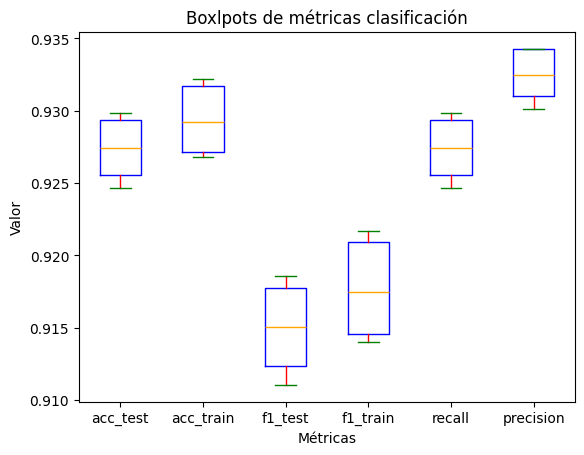

In [69]:
acc_test = [fold['Accuracy'] for fold in resultados_folds]
acc_train = [fold['Train_Accuracy'] for fold in resultados_folds]

f1_test = [fold['F1'] for fold in resultados_folds]
f1_train = [fold['Train_F1'] for fold in resultados_folds]

recall_test = [fold['Recall'] for fold in resultados_folds]
precision_test = [fold['Precision'] for fold in resultados_folds]

dict_met = {"acc_test":acc_test, "acc_train":acc_train, "f1_test":f1_test, "f1_train":f1_train, "recall":recall_test, "precision":precision_test}
plt.boxplot(dict_met.values(), boxprops=dict(color='blue'), whiskerprops=dict(color='red'), capprops=dict(color='green'), medianprops=dict(color='orange'), flierprops=dict(markerfacecolor='red', marker='o'), tick_labels=dict_met.keys())
plt.title('Boxlpots de métricas clasificación')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.show()

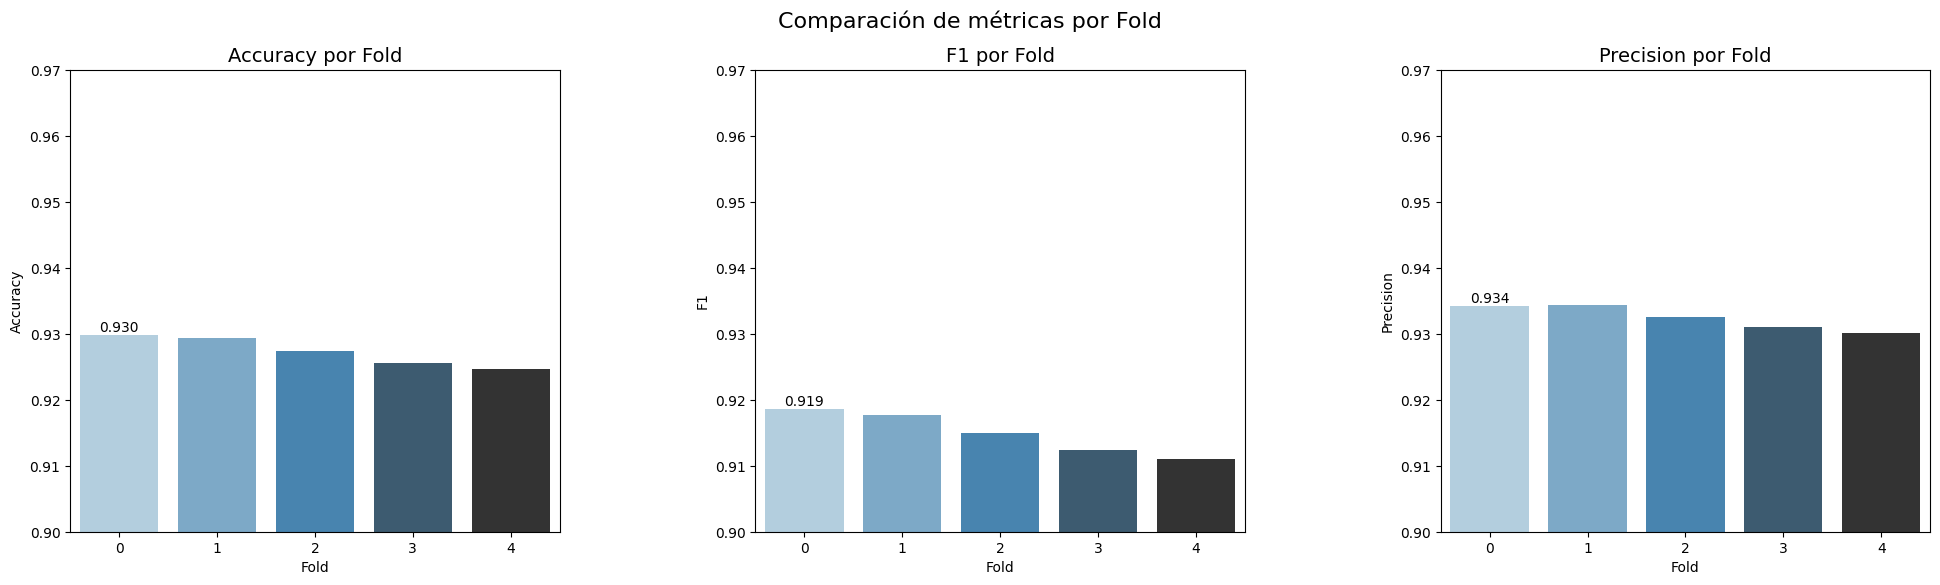

In [70]:
df_metrics = pd.DataFrame(resultados_folds)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.4)
axes = axes.ravel()

metrics = ['Accuracy', 'F1', 'Precision']

for metric, ax in zip(metrics, axes):
    sns.barplot(
        data=df_metrics,
        x='fold',
        y=metric,
        hue='fold',
        ax=ax,
        palette='Blues_d',
        legend=False
    )
    ax.set_title(f'{metric} por Fold', fontsize=14)
    ax.set_xlabel('Fold')
    ax.set_ylabel(metric)
    ax.set_ylim(0.90, 0.97)
    ax.bar_label(ax.containers[0], fmt='%.3f')

plt.suptitle('Comparación de métricas por Fold', fontsize=16)
plt.show()


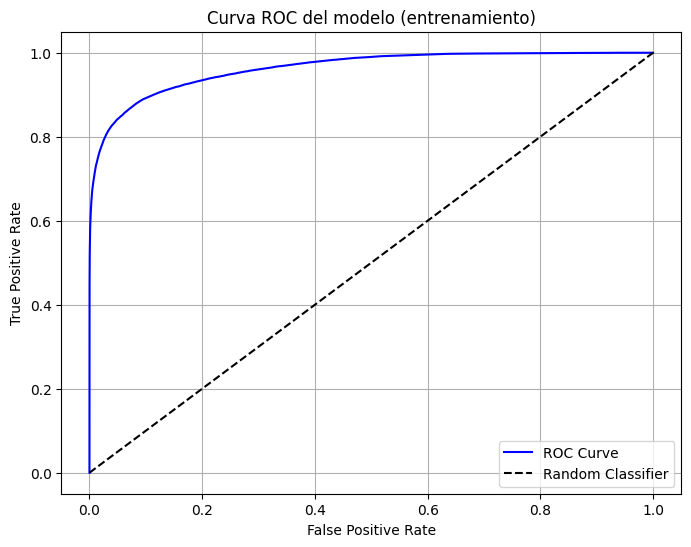

Área bajo la curva ROC (AUC) en el conjunto de entrenamiento: 0.9626


In [72]:
# Obtener resumen del modelo entrenado
trainingSummary = modelo.summary

# Convertir a Pandas la curva ROC
lrROC = trainingSummary.roc.toPandas()

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(lrROC['FPR'], lrROC['TPR'], label="ROC Curve", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC del modelo (entrenamiento)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Mostrar el valor de AUC
print(f'Área bajo la curva ROC (AUC) en el conjunto de entrenamiento: {trainingSummary.areaUnderROC:.4f}')


## 6.2 Modelos No Supervisados – Clustering

En esta sección se implementa un modelo de **aprendizaje no supervisado**, específicamente el algoritmo de **KMeans**, con el objetivo de descubrir agrupamientos naturales entre los clientes, sin utilizar etiquetas (`loan_status`) durante el entrenamiento.

Este tipo de análisis es útil para detectar **segmentos homogéneos** en la población, lo cual puede ser aprovechado en estrategias como personalización de productos, evaluación de riesgo o marketing dirigido.

Evaluación: Silhouette Score

Dado que no se cuenta con una variable objetivo para comparar los resultados, la calidad del agrupamiento se evalúa mediante la métrica:

- **Silhouette Score**: Indica qué tan similares son los elementos dentro de un mismo clúster y qué tan distintos son con respecto a otros clústeres. Sus valores van de -1 a 1, donde:
  - **+1**: agrupamientos bien definidos.
  - **0**: solapamiento entre clústeres.
  - **−1**: asignaciones incorrectas.

La evaluación se realiza con `ClusteringEvaluator` de PySpark, diseñado para funcionar de forma eficiente sobre grandes volúmenes de datos distribuidos.

---

En las siguientes celdas se muestra el código utilizado para entrenar el modelo KMeans y seleccionar el número óptimo de clústeres mediante la comparación de Silhouette Scores.

#### 6.2.1 Clustering con K-Means

El modelo de clustering K-Means busca dividir el conjunto de datos en `k` grupos (clusters), donde cada grupo contiene registros con características similares entre sí y diferentes de los otros grupos.

Para este proyecto:

- Se entrenó un modelo con **k = 3** clusters.
- El modelo fue aplicado sobre el conjunto `Train`, ya codificado y ensamblado previamente.
- Se generó una columna `prediction` con el número de clúster asignado a cada registro.


In [73]:
# Crear el modelo con k=3
kmeans_3 = KMeans(featuresCol="features", k=3, seed=1)

# Entrenar el modelo con el conjunto ya transformado (puede ser 'train' o 'M')
modelo_kmeans_3 = kmeans_3.fit(train)

# Aplicar el modelo al conjunto
predicciones_kmeans_3 = modelo_kmeans_3.transform(train)

# Mostrar algunas filas con el clúster asignado
predicciones_kmeans_3.select("features", "prediction").show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

#### 6.2.2 Determinación del número óptimo de clusters

Para verificar si el valor `k = 3` es adecuado, se probaron varios valores de `k` (entre 2 y 6) y se compararon los resultados utilizando una métrica de calidad.

In [74]:
# Evaluador de Silhouette
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")

# Evaluar para distintos valores de k
resultados_silhouette = []

for k in range(2, 7):  # de k=2 a k=6
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    modelo = kmeans.fit(train)
    pred = modelo.transform(train)
    silhouette = evaluator.evaluate(pred)
    
    resultados_silhouette.append((k, silhouette))
    print(f"Silhouette Score para k = {k}: {silhouette:.4f}")


Silhouette Score para k = 2: 0.7825
Silhouette Score para k = 3: 0.7428
Silhouette Score para k = 4: 0.7231
Silhouette Score para k = 5: 0.7027
Silhouette Score para k = 6: 0.7494


#### 6.2.3 Evaluación de agrupamientos (Silhouette Score)

La métrica utilizada fue el **Silhouette Score**, que indica qué tan bien definidos están los grupos formados:

- Valores cercanos a **1** indican clústeres bien separados.
- Valores cercanos a **0** indican grupos con fronteras poco claras.
- Valores negativos sugieren agrupamientos incorrectos.

La evaluación se realizó usando el módulo `ClusteringEvaluator` de PySpark, optimizado para entornos distribuidos.

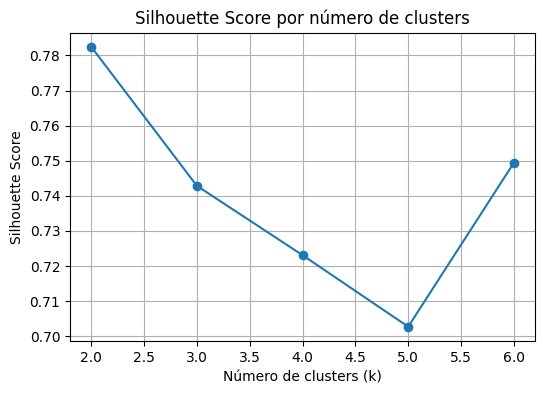

In [75]:
# Convertir resultados a DataFrame de pandas
df_silhouette = pd.DataFrame(resultados_silhouette, columns=["k", "silhouette_score"])

# Graficar
plt.figure(figsize=(6, 4))
plt.plot(df_silhouette["k"], df_silhouette["silhouette_score"], marker='o')
plt.title("Silhouette Score por número de clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()
